
子任务1：数据准备与预处理
数据基本信息:
数据形状: (1608290, 21)
数据列名: ['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type ']
数据清洗: 从 1608290 条记录过滤到 1568468 条记录
10分钟流量数据形状: (4464, 2)
流量数据前5行:
             datetime  traffic_count
0 2015-12-01 00:00:00            239
1 2015-12-01 00:10:00            177
2 2015-12-01 00:20:00            158
3 2015-12-01 00:30:00            159
4 2015-12-01 00:40:00            145


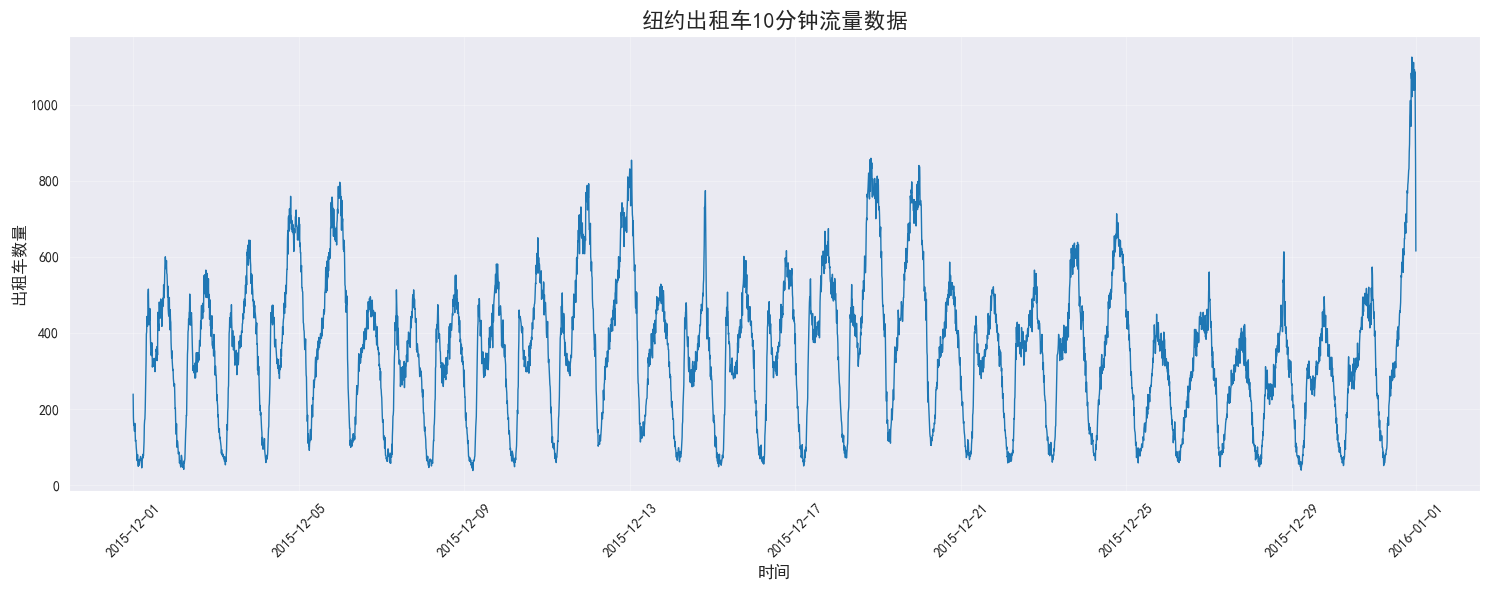


开始安全的特征工程和数据分割...
训练集时间段: 2015-12-01 00:00:00 到 2015-12-25 19:00:00
测试集时间段: 2015-12-25 19:10:00 到 2015-12-31 23:50:00
训练集清洗后: 3568 条记录
测试集清洗后: 893 条记录
训练集大小: (3568, 8)
测试集大小: (893, 8)
使用的特征: ['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_6']

子任务2：线性回归模型
线性回归模型训练完成!
线性回归模型性能:
均方误差 (MSE): 818.06
决定系数 (R²): 0.9762


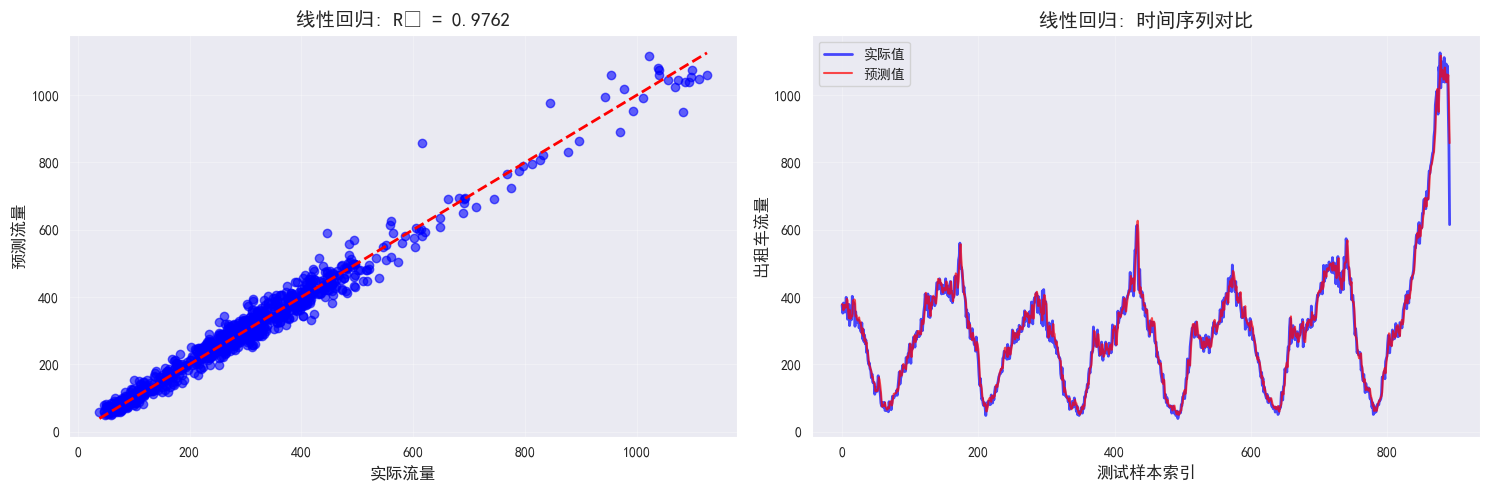


子任务3：决策树模型
决策树模型训练完成!
决策树深度: 8
决策树模型性能:
均方误差 (MSE): 1961.22
决定系数 (R²): 0.9429


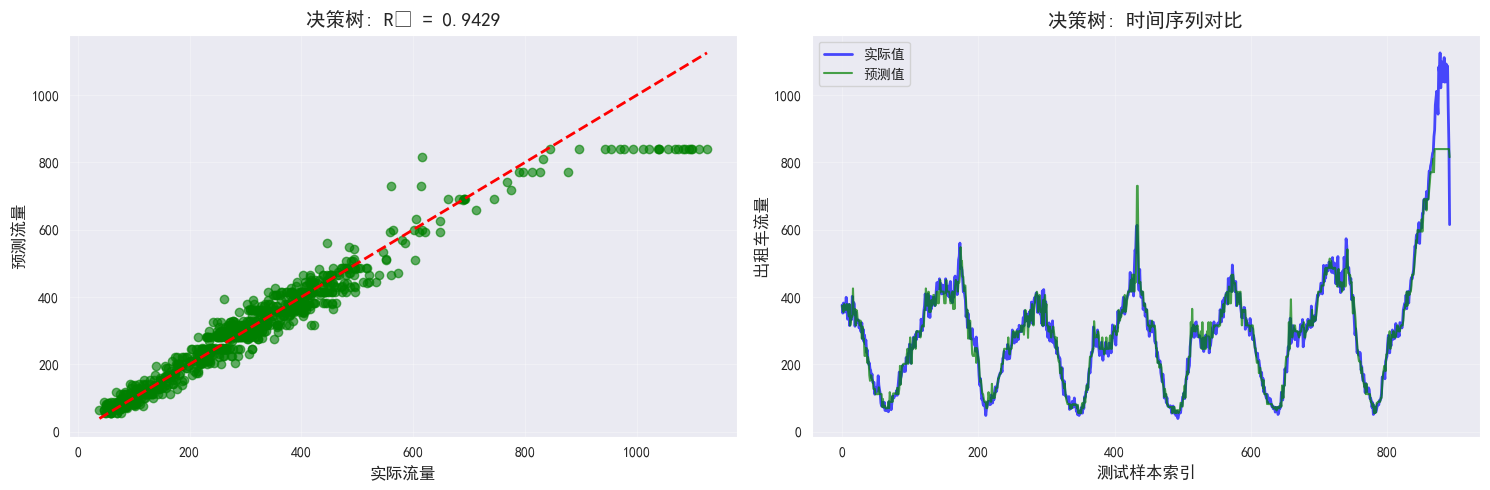


决策树特征重要性排序:
  lag_1: 0.9841
  rolling_mean_3: 0.0076
  hour: 0.0036
  lag_2: 0.0017
  rolling_mean_6: 0.0017
  lag_3: 0.0008
  day_of_week: 0.0004
  is_weekend: 0.0000

模型比较分析
模型性能比较:
     模型          MSE        R²
0  线性回归   818.063648  0.976174
1   决策树  1961.215535  0.942879


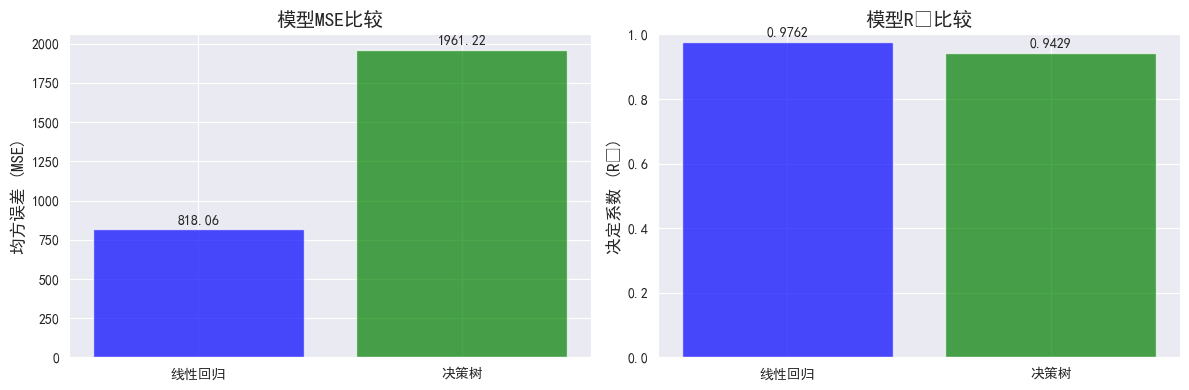


模型性能分析:
✓ 线性回归在MSE指标上表现更好
  线性回归比决策树MSE低 58.3%
✓ 线性回归在R²指标上表现更好
  线性回归比决策树R²高 0.0333

模型选择建议:
✓ 两个模型都表现出较好的预测能力

实验完成！


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')




# 子任务1：数据准备与预处理
print("\n" + "=" * 50)
print("子任务1：数据准备与预处理")
print("=" * 50)

# 1. 加载数据
file_path =r"D:\java学习\springcloud\green_tripdata_2015-12.csv"
df = pd.read_csv(file_path)

print("数据基本信息:")
print(f"数据形状: {df.shape}")
print(f"数据列名: {df.columns.tolist()}")

# 转换时间列
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['Lpep_dropoff_datetime'] = pd.to_datetime(df['Lpep_dropoff_datetime'])

# 计算行程时间
df['trip_duration'] = (df['Lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

# 过滤异常数据
initial_count = len(df)
df = df[df['trip_duration'] > 0]
df = df[df['trip_duration'] < 180]
df = df[df['Trip_distance'] > 0]
df = df[df['Trip_distance'] < 100]
df = df[df['Fare_amount'] > 0]
df = df[df['Fare_amount'] < 200]

print(f"数据清洗: 从 {initial_count} 条记录过滤到 {len(df)} 条记录")

# 计算每10分钟的流量数据
traffic_data = df.set_index('lpep_pickup_datetime').resample('10T').size().reset_index()
traffic_data.columns = ['datetime', 'traffic_count']

print(f"10分钟流量数据形状: {traffic_data.shape}")
print("流量数据前5行:")
print(traffic_data.head())

# 2. 可视化流量数据
plt.figure(figsize=(15, 6))
plt.plot(traffic_data['datetime'], traffic_data['traffic_count'], linewidth=1)
plt.title('纽约出租车10分钟流量数据', fontsize=16)
plt.xlabel('时间', fontsize=12)
plt.ylabel('出租车数量', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 安全的特征工程和数据分割
print("\n开始安全的特征工程和数据分割...")

# 首先按时间排序
traffic_data = traffic_data.sort_values('datetime').reset_index(drop=True)

# 按时间顺序分割数据集（前80%训练，后20%测试）
split_index = int(len(traffic_data) * 0.8)
train_data = traffic_data.iloc[:split_index].copy()
test_data = traffic_data.iloc[split_index:].copy()

print(f"训练集时间段: {train_data['datetime'].iloc[0]} 到 {train_data['datetime'].iloc[-1]}")
print(f"测试集时间段: {test_data['datetime'].iloc[0]} 到 {test_data['datetime'].iloc[-1]}")

# 为训练集创建特征（只用训练集自身数据）
train_data['hour'] = train_data['datetime'].dt.hour
train_data['day_of_week'] = train_data['datetime'].dt.dayofweek
train_data['is_weekend'] = (train_data['day_of_week'] >= 5).astype(int)

# 训练集滞后特征（只用训练集历史数据）
train_data['lag_1'] = train_data['traffic_count'].shift(1)
train_data['lag_2'] = train_data['traffic_count'].shift(2)
train_data['lag_3'] = train_data['traffic_count'].shift(3)

# 训练集移动平均特征（排除当前点，只用历史数据）
train_data['rolling_mean_3'] = train_data['traffic_count'].shift(1).rolling(window=3, min_periods=1).mean()
train_data['rolling_mean_6'] = train_data['traffic_count'].shift(1).rolling(window=6, min_periods=1).mean()

# 为测试集创建特征
test_data['hour'] = test_data['datetime'].dt.hour
test_data['day_of_week'] = test_data['datetime'].dt.dayofweek
test_data['is_weekend'] = (test_data['day_of_week'] >= 5).astype(int)

# 测试集滞后特征（用训练集最后的值初始化）
last_train_values = train_data['traffic_count'].tail(3).tolist()

# 为测试集计算滞后特征
traffic_values = last_train_values + test_data['traffic_count'].tolist()
temp_series = pd.Series(traffic_values)

test_data['lag_1'] = temp_series.shift(1).iloc[len(last_train_values):].values
test_data['lag_2'] = temp_series.shift(2).iloc[len(last_train_values):].values
test_data['lag_3'] = temp_series.shift(3).iloc[len(last_train_values):].values

# 测试集移动平均特征
test_data['rolling_mean_3'] = temp_series.shift(1).rolling(window=3, min_periods=1).mean().iloc[len(last_train_values):].values
test_data['rolling_mean_6'] = temp_series.shift(1).rolling(window=6, min_periods=1).mean().iloc[len(last_train_values):].values

# 删除包含NaN的行
train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

print(f"训练集清洗后: {len(train_data_clean)} 条记录")
print(f"测试集清洗后: {len(test_data_clean)} 条记录")

# 准备特征和目标变量
feature_columns = ['hour', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_6']

X_train = train_data_clean[feature_columns]
y_train = train_data_clean['traffic_count']
X_test = test_data_clean[feature_columns]
y_test = test_data_clean['traffic_count']

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"使用的特征: {feature_columns}")

# 子任务2：线性回归模型
print("\n" + "=" * 50)
print("子任务2：线性回归模型")
print("=" * 50)

# 训练线性回归模型
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("线性回归模型训练完成!")

# 在测试集上进行预测
y_pred_lr = lr_model.predict(X_test)

# 计算评估指标
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"线性回归模型性能:")
print(f"均方误差 (MSE): {mse_lr:.2f}")
print(f"决定系数 (R²): {r2_lr:.4f}")

# 绘制实际值与预测值的对比图
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='blue')
max_val = max(y_test.max(), y_pred_lr.max())
min_val = min(y_test.min(), y_pred_lr.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('实际流量', fontsize=12)
plt.ylabel('预测流量', fontsize=12)
plt.title(f'线性回归: R² = {r2_lr:.4f}', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sample_indices = range(len(y_test))
plt.plot(sample_indices, y_test.values, 'b-', label='实际值', alpha=0.7, linewidth=2)
plt.plot(sample_indices, y_pred_lr, 'r-', label='预测值', alpha=0.7)
plt.xlabel('测试样本索引', fontsize=12)
plt.ylabel('出租车流量', fontsize=12)
plt.title('线性回归: 时间序列对比', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 子任务3：决策树模型
print("\n" + "=" * 50)
print("子任务3：决策树模型")
print("=" * 50)

# 训练决策树模型
dt_model = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=5)
dt_model.fit(X_train, y_train)

print("决策树模型训练完成!")
print(f"决策树深度: {dt_model.get_depth()}")

# 在测试集上进行预测
y_pred_dt = dt_model.predict(X_test)

# 计算评估指标
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"决策树模型性能:")
print(f"均方误差 (MSE): {mse_dt:.2f}")
print(f"决定系数 (R²): {r2_dt:.4f}")

# 绘制实际值与预测值的对比图
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_dt, alpha=0.6, color='green')
max_val = max(y_test.max(), y_pred_dt.max())
min_val = min(y_test.min(), y_pred_dt.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('实际流量', fontsize=12)
plt.ylabel('预测流量', fontsize=12)
plt.title(f'决策树: R² = {r2_dt:.4f}', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sample_indices = range(len(y_test))
plt.plot(sample_indices, y_test.values, 'b-', label='实际值', alpha=0.7, linewidth=2)
plt.plot(sample_indices, y_pred_dt, 'g-', label='预测值', alpha=0.7)
plt.xlabel('测试样本索引', fontsize=12)
plt.ylabel('出租车流量', fontsize=12)
plt.title('决策树: 时间序列对比', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 特征重要性
feature_names = X_train.columns
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\n决策树特征重要性排序:")
for i in indices:
    print(f"  {feature_names[i]}: {importances[i]:.4f}")

# 模型比较
print("\n" + "=" * 50)
print("模型比较分析")
print("=" * 50)

# 创建比较表格
comparison_df = pd.DataFrame({
    '模型': ['线性回归', '决策树'],
    'MSE': [mse_lr, mse_dt],
    'R²': [r2_lr, r2_dt]
})

print("模型性能比较:")
print(comparison_df)

# 可视化比较
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
models = ['线性回归', '决策树']
mse_values = [mse_lr, mse_dt]
bars = plt.bar(models, mse_values, color=['blue', 'green'], alpha=0.7)
plt.ylabel('均方误差 (MSE)', fontsize=12)
plt.title('模型MSE比较', fontsize=14)

for bar, value in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mse_values)*0.01,
            f'{value:.2f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
r2_values = [r2_lr, r2_dt]
bars = plt.bar(models, r2_values, color=['blue', 'green'], alpha=0.7)
plt.ylabel('决定系数 (R²)', fontsize=12)
plt.title('模型R²比较', fontsize=14)
plt.ylim(0, 1)

for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 详细分析
print("\n模型性能分析:")
if mse_lr < mse_dt:
    print("✓ 线性回归在MSE指标上表现更好")
    mse_improvement = ((mse_dt - mse_lr) / mse_dt) * 100
    print(f"  线性回归比决策树MSE低 {mse_improvement:.1f}%")
else:
    print("✓ 决策树在MSE指标上表现更好")
    mse_improvement = ((mse_lr - mse_dt) / mse_lr) * 100
    print(f"  决策树比线性回归MSE低 {mse_improvement:.1f}%")

if r2_lr > r2_dt:
    print("✓ 线性回归在R²指标上表现更好")
    r2_difference = r2_lr - r2_dt
    print(f"  线性回归比决策树R²高 {r2_difference:.4f}")
else:
    print("✓ 决策树在R²指标上表现更好")
    r2_difference = r2_dt - r2_lr
    print(f"  决策树比线性回归R²高 {r2_difference:.4f}")

print("\n模型选择建议:")
if r2_lr > 0.7 or r2_dt > 0.7:
    print("✓ 两个模型都表现出较好的预测能力")
elif r2_lr > 0.5 or r2_dt > 0.5:
    print("✓ 模型预测能力一般，可以考虑用于实际预测")
else:
    print("✓ 模型预测能力较差，需要进一步优化特征工程")

print("\n" + "=" * 60)
print("实验完成！")
print("=" * 60)